In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import torch
import numpy as np
from time import time
from torch.utils.data import Dataset, DataLoader

Optimality Gap & Inference Time

In [2]:
class Data_Len(Dataset):
    def __init__(self, n=50, cuda=False):
        self.data, self.lens = load_data(n, cuda)
    def __getitem__(self, i):
        return self.data[i], self.lens[i]
    def __len__(self):
        return self.data.size(0)
        
def load_data(n=50, cuda=False):
    data_path = os.path.join('data', f'10k_TSP{n}.pt')
    len_path = os.path.join('data', f'10k_TSP{n}_len.pt')
    print(data_path)
    with open(data_path, 'rb') as f_data, open(len_path, 'rb') as f_len:
        data = torch.load(f_data)
        lens = torch.load(f_len)
    if cuda:
        data = data.cuda()
        lens = lens.cuda()
    return data, lens

def load_model(n=100, attn_type=0, segm=25):
    path = os.path.join('logs', f'tsp{n}_att{attn_type}')
    if n == 50 and attn_type > 0:
        path = f'logs/tsp50_att{attn_type}_seg{segm}'
    if n == 100 and segm == 50:
        path = f'logs/tsp100_att{attn_type}_seg50'
    model_path = os.path.join(path, 'model.pt')
    with open(model_path, 'rb') as f_model:
        model = torch.load(f_model)
    return model

def compute_tour_length(tour, x): 
    """
    Original code from : github.com/xbresson
    Compute the length of a batch of tours
    Inputs : x of size (N, B, 2) batch of tsp tour instances
             tour of size (N, B) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    x = x.permute(1,0,2).contiguous()  # (B, N, 2)
    tour = tour.permute(1,0).contiguous()  # (B, N)
    bsz = x.shape[0]
    nb_nodes = tour.shape[1]
    arange_vec = torch.arange(bsz, device=x.device)
    first_cities = x[arange_vec, tour[:,0], :] # size(first_cities)=(bsz,2)
    previous_cities = first_cities
    L = torch.zeros(bsz, device=x.device)
    with torch.no_grad():
        for i in range(1,nb_nodes):
            current_cities = x[arange_vec, tour[:,i], :] 
            L += torch.sum( (current_cities - previous_cities)**2 , dim=1 )**0.5 # dist(current, previous node) 
            previous_cities = current_cities
        L += torch.sum( (current_cities - first_cities)**2 , dim=1 )**0.5 # dist(last, first node)  
    return L

def np_compute_tour_length(tour, x): 
    """
    Original code from : github.com/xbresson
    Compute the length of a batch of tours (Numpy single instance version)
    Inputs : x of size (N, 2) tsp tour instance
             tour of size (N) sequences (node indices) of tsp tours
    Output : L 
    """
    # x = x.permute(1,0,2).contiguous()  # (B, N, 2)
    # tour = tour.permute(1,0).contiguous()  # (B, N)
    # bsz = x.shape[0]
    nb_nodes = x.shape[0]
    first_cities = x[tour[0]] # size(first_cities)=(bsz,2)
    previous_cities = first_cities
    L = 0
    for i in range(1,nb_nodes):
        current_cities = x[tour[i]] 
        L += np.sum( (current_cities - previous_cities)**2 )**0.5 # dist(current, previous node) 
        previous_cities = current_cities
    L += np.sum( (current_cities - first_cities)**2 )**0.5 # dist(last, first node)  
    return L

In [3]:
# tsp50_att0
model = load_model(n=50, attn_type=0, segm=None)

dataloader = DataLoader(Data_Len(n=50, cuda=True), batch_size=512)

st = time()
mean_opt_gaps_list = []
for data, lens in dataloader:
    data = data.permute(1,0,2)
    tour, _, _ = model(data, True)
    pred_lens = compute_tour_length(tour, data)
    gap = pred_lens / lens - 1
    mean_opt_gaps_list.append(gap.mean().item())
print(time() - st)
print(np.mean(mean_opt_gaps_list))

data/10k_TSP50.pt
4.449453115463257
0.039715068973600866


In [17]:
# tsp50_att1_seg25
model = load_model(n=50, attn_type=1, segm=25)

dataloader = DataLoader(Data_Len(n=50, cuda=True), batch_size=512)

st = time()
mean_opt_gaps_list = []
for data, lens in dataloader:
    data = data.permute(1,0,2)
    tour, _, _ = model(data, True)
    pred_lens = compute_tour_length(tour, data)
    gap = pred_lens / lens - 1
    mean_opt_gaps_list.append(gap.mean().item())
print(time() - st)
print(np.mean(mean_opt_gaps_list))

data/10k_TSP50.pt
3.6899478435516357
0.039911978878080845


In [5]:
# tsp100_att0
model = load_model(n=100, attn_type=0, segm=None)

dataloader = DataLoader(Data_Len(n=100, cuda=True), batch_size=200)

st = time()
mean_opt_gaps_list = []
for data, lens in dataloader:
    data = data.permute(1,0,2)
    tour, _, _ = model(data, True)
    pred_lens = compute_tour_length(tour, data)
    gap = pred_lens / lens - 1
    mean_opt_gaps_list.append(gap.mean().item())
print(time() - st)
print(np.mean(mean_opt_gaps_list))

data/10k_TSP100.pt
18.344159364700317
0.06327628299593925


In [6]:
# tsp100_att1
model = load_model(n=100, attn_type=1, segm=25)

dataloader = DataLoader(Data_Len(n=100, cuda=True), batch_size=200)

st = time()
mean_opt_gaps_list = []
for data, lens in dataloader:
    data = data.permute(1,0,2)
    tour, _, _ = model(data, True)
    pred_lens = compute_tour_length(tour, data)
    gap = pred_lens / lens - 1
    mean_opt_gaps_list.append(gap.mean().item())
print(time() - st)
print(np.mean(mean_opt_gaps_list))

data/10k_TSP100.pt
16.47312879562378
0.06282825782895088


# Tour Visualization

In [18]:
# Extract single instance
data = data[:,0].cpu().numpy()  # (N, 2)
tour = tour[:,0].cpu().numpy()  # (N)
print(data.shape, tour.shape)

(50, 2) (50,)


In [25]:
import matplotlib.pyplot as plt
from concorde.tsp import TSPSolver

def viz_tour(data, tour):
    sample = data[tour]
    plt.scatter(sample[:,0], sample[:,1])
    for i in range(sample.shape[0]-1):
        x = [sample[i,0], sample[i+1,0]]
        y = [sample[i,1], sample[i+1,1]]
        plt.plot(x, y, color='black')
    x = [sample[i,0], sample[0,0]]
    y = [sample[i,1], sample[0,1]]
    plt.plot(x, y, color='black')

def exhaust(data):
    data = data.copy()
    tour = []
    idx = 0
    N = data.shape[0]
    for _ in range(N):
        tour.append(idx)
        point = data[idx].copy()
        data[idx, :] = 1000, 1000
        point_rep = np.repeat(np.expand_dims(point, 0), repeats=N, axis=0)
        distances = np.sqrt(np.sum((data - point_rep)**2, axis=1))
        idx = distances.argmin()
    return tour

7.438982398483399

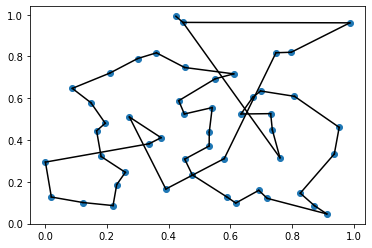

In [30]:
# Exhaustive search
tour_exh = exhaust(data)
viz_tour(data, tour_exh)
np_compute_tour_length(tour_exh, data)

5.991838550327241

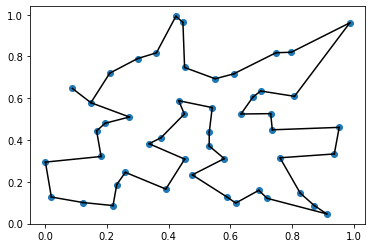

In [33]:
# Model prediction
viz_tour(data, tour)
np_compute_tour_length(tour, data)

Problem Name: f6336738904448e391dfdf50dfbd3c8f
Problem Type: TSP
Number of Nodes: 50
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 0
   0 Steps   Best: 0   0.00 seconds
  25 Total Steps.
Best cycle length: 0
Lin-Kernighan Running Time: 0.10
LK Initial Run: 0.0
LK Run 0: 0.0
LK Run from best tour: 0.0
Time to find compression tour: 0.40 (seconds)
Set initial upperbound to 0 (from tour)
Fractional Matching: 0.0
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 0.00
Loading lp...done in 0.00 seconds
LP has:  50 rows  166 columns  332 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 0.000000
Setting tolerances: next cuts 0.0100 next round 0.0010
CCtsp_init_edgegenerator (50)
 1225 edges
LP has:  50 rows  166 columns  332 nonzeros
Loading lp...done i

15.18084677783479

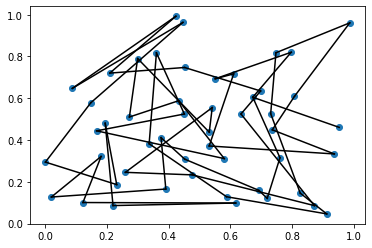

In [34]:
# Concorde
solver = TSPSolver.from_data(data[:,0], data[:,1], norm='EUC_2D')
solution = solver.solve()
tour_label = solution[0]
viz_tour(data, tour_label)
np_compute_tour_length(tour_label, data)